In [1]:
import numpy as np
import pandas as pd
import json
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from mllib.params import FieldNames, FileNames
from mllib.utils import load_pickle
from mllib.transformers import ListLen, SetLen, ListAggregation

In [2]:
def make_x_y(x_tr, x_val, flag='val'):
    y_tr = x_tr['redemption_status'].values

    if flag == 'val':
        y_val = x_val['redemption_status'].values
    else:
        y_val = None
    return x_tr, y_tr, x_val, y_val


def get_rank_features(df):
    df['cust_coupon_rank1'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_0'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank2'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_1'].rank('max')/df['customer_campaign_count']
    df['cust_coupon_rank3'] = df.groupby(['customer_id', 'campaign_id'])['common_item_set_2'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank4'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_0'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank5'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_1'].rank('max')/df['customer_campaign_count']
    #df['cust_coupon_rank6'] = df.groupby(['customer_id', 'campaign_id'])['common_brand_2'].rank('max')/df['customer_campaign_count']

    df['customer_rank1'] = df.groupby(['customer_id'])['common_item_set_1'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank2'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    df['customer_rank3'] = df.groupby(['customer_id'])['common_category_1'].rank('max')/df.groupby('customer_id').size()

    # df['customer_rank4'] = df.groupby(['customer_id'])['common_brand_1'].rank('max')/df.groupby('customer_id').size()
    # df['customer_rank3'] = df.groupby(['customer_id'])['common_item_set_2'].rank('max')/df.groupby('customer_id').size()
    df['campaign_rank1'] = df.groupby(['campaign_id'])['common_item_set_0'].rank('max')/df.groupby('campaign_id').size()
    df['campaign_rank2'] = df.groupby(['campaign_id'])['common_brand_0'].rank('max')/df.groupby('campaign_id').size()

    #df['campaign_rank2'] = df.groupby(['campaign_id'])['common_item_set_1'].rank('max')/df.groupby('campaign_id').size()
    #df['campaign_rank3'] = df.groupby(['campaign_id'])['common_item_set_2'].rank('max')/df.groupby('campaign_id').size()
    #df['coupon_rank1'] = df.groupby(['coupon_id'])['common_item_set_0'].rank('max')/df.groupby('coupon_id').size()
    df['coupon_rank1'] = df.groupby(['coupon_id'])['common_brand_0'].rank('max')/df.groupby('coupon_id').size()

    #df['coupon_rank2'] = df.groupby(['coupon_id'])['common_item_set_1'].rank('max')/df.groupby('coupon_id').size()

    return df


def load_data(flag='val'):
    if flag == 'val':
        x_tr = load_pickle(FileNames.tr_features_v3)
        x_val = load_pickle(FileNames.val_features_v3)
    elif flag == 'test':
        x_tr = load_pickle(FileNames.train_features_v3)
        x_val = load_pickle(FileNames.test_features_v3)
    
    return make_x_y(x_tr, x_val, flag=flag)


def map_campign_id(x_tr, x_val, flag='val'):
    if flag == 'val':
        tr = load_pickle(FileNames.tr_v2)
        val = load_pickle(FileNames.val_v2)
    elif flag == 'test':
        tr = load_pickle(FileNames.train_v2)
        val = load_pickle(FileNames.test_v2)
        
    x_tr['campaign_id'] = tr['campaign_id'].values
    x_val['campaign_id'] = val['campaign_id'].values
    return x_tr, x_val

In [3]:
from mllib.targetencoder import TargetEncoderWithThresh

In [4]:
x_tr, y_tr, x_val, y_val = load_data('val')
x_tr, x_val = map_campign_id(x_tr, x_val, 'val')

In [5]:
n_feats = x_tr.shape[1] - 1
n_feats

387

In [6]:
x_tr = get_rank_features(x_tr)
x_val = get_rank_features(x_val)

In [7]:
y_tr = y_tr[x_tr.coupon_id != 8]
x_tr = x_tr.loc[x_tr.coupon_id != 8]


In [13]:
lgb_params = {
    "n_estimators": 100000,
    "boosting_type": "gbdt",
    "num_leaves": 3,
    "max_depth": 2,
    "colsample_bytree": 0.4,
    "metric": None,
    "subsample": 0.8,
    "learning_rate": 0.003,
    "reg_lambda": 1,
    "reg_alpha": 1,
    "min_data_in_leaf": 713,
    "min_child_samples": 200,
    "max_bin": 255,
    "cat_smooth": 50,
    "max_cat_threshold": 32,
    "cat_l2": 50,
    "seed": 78612356,
    "allow_nan": True
}
model = lgb.LGBMClassifier(**lgb_params)

feats = [f for i, f in enumerate(x_tr.columns) if ('coupon_details' not in f) and ('common_repeats' not in f) and
         (f not in ['campaign_id', 'customer_campaign_count', 'redemption_status'])] 
#xx_tr = qnt.fit_transform(x_tr[feats].fillna(-999))
#xx_val = qnt.fit_transform(x_val[feats].fillna(-999))
model.fit(x_tr[feats], y_tr, eval_set=[(x_tr[feats], y_tr), (x_val[feats], y_val)], eval_metric='auc', verbose=50, early_stopping_rounds=400) 
val_preds = model.predict_proba(x_val[feats])[:, 1]

Training until validation scores don't improve for 400 rounds
[50]	valid_0's auc: 0.889504	valid_1's auc: 0.89693
[100]	valid_0's auc: 0.899592	valid_1's auc: 0.911004
[150]	valid_0's auc: 0.904283	valid_1's auc: 0.914813
[200]	valid_0's auc: 0.905422	valid_1's auc: 0.915239
[250]	valid_0's auc: 0.906198	valid_1's auc: 0.916055
[300]	valid_0's auc: 0.90973	valid_1's auc: 0.917351
[350]	valid_0's auc: 0.910628	valid_1's auc: 0.918331
[400]	valid_0's auc: 0.913009	valid_1's auc: 0.919872
[450]	valid_0's auc: 0.913777	valid_1's auc: 0.920519
[500]	valid_0's auc: 0.914689	valid_1's auc: 0.92107
[550]	valid_0's auc: 0.914955	valid_1's auc: 0.921559
[600]	valid_0's auc: 0.915893	valid_1's auc: 0.922282
[650]	valid_0's auc: 0.916905	valid_1's auc: 0.923302
[700]	valid_0's auc: 0.917769	valid_1's auc: 0.924252
[750]	valid_0's auc: 0.918801	valid_1's auc: 0.925442
[800]	valid_0's auc: 0.92057	valid_1's auc: 0.927253
[850]	valid_0's auc: 0.921483	valid_1's auc: 0.928404
[900]	valid_0's auc: 0.92

[7500]	valid_0's auc: 0.952417	valid_1's auc: 0.947327
[7550]	valid_0's auc: 0.952509	valid_1's auc: 0.947332
[7600]	valid_0's auc: 0.952616	valid_1's auc: 0.947337
[7650]	valid_0's auc: 0.952722	valid_1's auc: 0.947331
[7700]	valid_0's auc: 0.952813	valid_1's auc: 0.947327
[7750]	valid_0's auc: 0.952913	valid_1's auc: 0.947331
[7800]	valid_0's auc: 0.95299	valid_1's auc: 0.947347
[7850]	valid_0's auc: 0.953081	valid_1's auc: 0.947341
[7900]	valid_0's auc: 0.95318	valid_1's auc: 0.947342
[7950]	valid_0's auc: 0.953264	valid_1's auc: 0.947334
[8000]	valid_0's auc: 0.953355	valid_1's auc: 0.947361
[8050]	valid_0's auc: 0.953449	valid_1's auc: 0.947385
[8100]	valid_0's auc: 0.95353	valid_1's auc: 0.947395
[8150]	valid_0's auc: 0.953617	valid_1's auc: 0.94742
[8200]	valid_0's auc: 0.953729	valid_1's auc: 0.947412
[8250]	valid_0's auc: 0.953822	valid_1's auc: 0.94742
[8300]	valid_0's auc: 0.953909	valid_1's auc: 0.947411
[8350]	valid_0's auc: 0.954006	valid_1's auc: 0.947423
[8400]	valid_0'

In [14]:
x_train, y_train, x_test, _ = load_data('test')
x_train, x_test = map_campign_id(x_train, x_test, 'test')
x_train = get_rank_features(x_train)
x_test = get_rank_features(x_test)

#train = load_pickle(FileNames.train_v2)
#test = load_pickle(FileNames.test_v2)
#hist_artifact = load_pickle(FileNames.cust_train_artifact1)
#x_tr = map_brand_categories(x_tr, tr, hist_artifact)
#x_val = map_brand_categories(x_val, val, hist_artifact)

y_train = y_train[x_train.coupon_id != 8]
x_train = x_train.loc[x_train.coupon_id != 8]

#cvlist = StratifiedKFold(10, random_state=123).split(x_tr, y_tr)
#x_tr['cust_trenc'] = cross_val_predict(trenc, x_tr, y_tr, cv=cvlist, n_jobs=-1, method='transform')
#x_val['cust_trenc'] = trenc.fit(x_tr).transform(x_val)

In [15]:
lgb_params['n_estimators'] = 9500
model = lgb.LGBMClassifier(**lgb_params)

model.fit(x_train[feats], y_train, eval_set=[(x_train[feats], y_train)], eval_metric='auc', verbose=50)
test_preds = model.predict_proba(x_test[feats])[:, 1]

[50]	valid_0's auc: 0.903999
[100]	valid_0's auc: 0.909394
[150]	valid_0's auc: 0.910841
[200]	valid_0's auc: 0.913004
[250]	valid_0's auc: 0.915065
[300]	valid_0's auc: 0.916877
[350]	valid_0's auc: 0.919285
[400]	valid_0's auc: 0.920728
[450]	valid_0's auc: 0.922566
[500]	valid_0's auc: 0.923801
[550]	valid_0's auc: 0.924485
[600]	valid_0's auc: 0.925337
[650]	valid_0's auc: 0.926161
[700]	valid_0's auc: 0.927089
[750]	valid_0's auc: 0.92855
[800]	valid_0's auc: 0.929708
[850]	valid_0's auc: 0.930785
[900]	valid_0's auc: 0.931757
[950]	valid_0's auc: 0.932821
[1000]	valid_0's auc: 0.933725
[1050]	valid_0's auc: 0.934257
[1100]	valid_0's auc: 0.934892
[1150]	valid_0's auc: 0.935299
[1200]	valid_0's auc: 0.935848
[1250]	valid_0's auc: 0.936257
[1300]	valid_0's auc: 0.93666
[1350]	valid_0's auc: 0.937137
[1400]	valid_0's auc: 0.937482
[1450]	valid_0's auc: 0.937838
[1500]	valid_0's auc: 0.938081
[1550]	valid_0's auc: 0.938468
[1600]	valid_0's auc: 0.938833
[1650]	valid_0's auc: 0.939125

/home/mohsin/kg7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


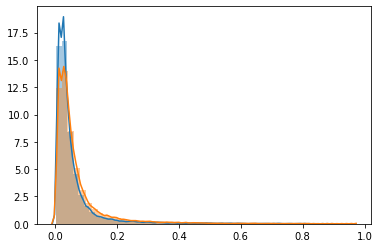

In [16]:
sns.distplot(np.sqrt(val_preds))
sns.distplot(np.sqrt(test_preds))

In [17]:
test = pd.read_csv('data/test.csv')
sub = test[['id']]
sub['redemption_status'] = test_preds
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.408516
1,4,0.012943
2,5,0.011043
3,8,0.000658
4,10,0.000626


In [18]:
sub.to_csv('data/sub_model13.csv', index=False)

In [20]:
sube1 = pd.read_csv('sub_en1.csv')
sub1 = pd.read_csv('data/sub_model8.csv')

In [21]:
sub2 =pd.read_csv('data/sub_model9.csv')

In [22]:
#sub = sub1['redemption_status']* + sube1['redemption_status']*

In [23]:
from scipy.stats import spearmanr

In [25]:
#spearmanr(test_preds, tmp.redemption_status)

In [31]:
spearmanr(test_preds, sub1.redemption_status)

SpearmanrResult(correlation=0.9770148311504376, pvalue=0.0)

In [29]:
spearmanr(test_preds, sub2.redemption_status)

SpearmanrResult(correlation=0.97845476253656, pvalue=0.0)

In [30]:
spearmanr(test_preds, sube1.redemption_status)

SpearmanrResult(correlation=0.9805996999383747, pvalue=0.0)

In [33]:
from scipy.stats import gmean
sub = test[['id']]
sub['redemption_status'] = gmean([test_preds, sub1['redemption_status'], sub2['redemption_status']])
sub.head()

/home/mohsin/kg7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,id,redemption_status
0,3,0.411612
1,4,0.008415
2,5,0.011559
3,8,0.000850
4,10,0.000772


In [34]:
sub.to_csv('data/sub_en3.csv', index=False)